# Task 2: Setup

In [31]:
!pip install -q pydub

In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)

2.5.0
4.0.1


In [33]:
dataset = tfds.load("gtzan_music_speech")

# Task 3: Explore the Data

In [67]:
train = dataset["train"]

data_iter = iter(train)

In [35]:
example = next(data_iter)
example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [36]:
audio = example.get("audio")
label = example.get("label")

print(label.numpy())

Audio(audio, rate=22050)

0


In [37]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [38]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

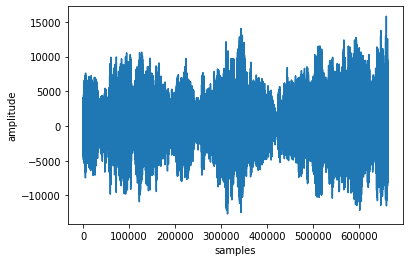

In [39]:
plot_waveform(audio)

# Task 4: Spectrogram

In [40]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256): #frame length is the length of time interval for audio to be sliced into
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [41]:
audio_stft = get_stft(audio)
audio_stft

<tf.Tensor: shape=(1288, 129), dtype=complex64, numpy=
array([[ 4619.413   +0.00000000e+00j,  -316.44568 +2.07166284e+03j,
          547.89966 -1.92087109e+03j, ...,   -33.986755-3.63452148e+00j,
          -25.922943-2.35644531e+00j,   -26.036377+0.00000000e+00j],
       [ 2427.6772  +0.00000000e+00j, -2974.0505  +6.51359741e+02j,
          581.0381  -1.65341028e+03j, ...,  -269.45865 +9.80383301e+00j,
         -266.10522 +1.94604492e+00j,  -259.75146 +0.00000000e+00j],
       [ 1059.03    +0.00000000e+00j, -4484.532   +2.19730029e+03j,
        -3554.751   -1.68795679e+03j, ...,   228.43262 -7.27508545e+00j,
          227.52148 +6.78100586e-01j,   224.00647 +0.00000000e+00j],
       ...,
       [ 4527.381   +0.00000000e+00j,   801.7986  +1.82363477e+03j,
          837.7906  +1.23493286e+02j, ...,  -223.52313 +9.13769150e+00j,
         -226.8208  +6.86401367e+00j,  -235.65308 +0.00000000e+00j],
       [ 3790.2402  +0.00000000e+00j, -1452.6903  +3.91958594e+03j,
        -5324.343   +3.82

In [42]:
audio_spec = tf.abs(audio_stft)

In [43]:
def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

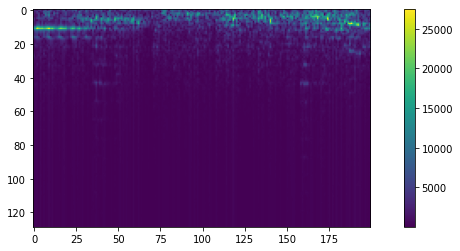

In [44]:
plot_spec(audio_spec[:200])

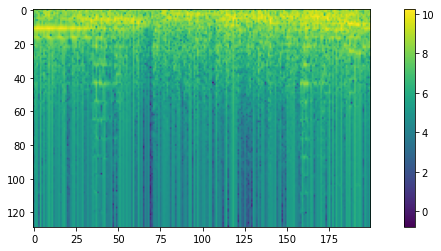

In [97]:
audio_spec_log = tf.transpose(get_spectrogram(audio))
plot_spec(audio_spec_log[:200])

In [46]:
def get_spectrogram(audio):
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

# Task 5: Prepare the Data

In [79]:
sr = 22050 # samples per second
chunk_len = 5 # seconds

def preprocess(example):
  audio = example.get("audio")
  label = example.get("label")

  x_batch,y_batch = None,None

  for i in range(0,6):
    start_sample = i*chunk_len*sr
    end_sample = (i+1)*chunk_len*sr
    audio_chunk = audio[start_sample:end_sample]
    audio_spec = get_spectrogram(audio_chunk)
    audio_spec = tf.expand_dims(audio_spec,axis=0)
    current_label = tf.expand_dims(label,axis=0)

    x_batch = audio_spec if x_batch is None else tf.concat([x_batch, audio_spec], axis = 0)
    y_batch = current_label if y_batch is None else tf.concat([y_batch, current_label], axis = 0)
  return x_batch,y_batch

In [80]:
x_train,y_train = None,None

for example in tqdm(iter(train)):
  x_batch, y_batch = preprocess(example)

  x_train = x_batch if x_train is None else tf.concat([x_train, x_batch], axis = 0)
  y_train = y_batch if y_train is None else tf.concat([y_train, y_batch], axis = 0)


128it [00:04, 27.58it/s]


In [81]:
print(x_train.shape, y_train.shape)

(768, 129, 212) (768,)


In [82]:
indices = tf.random.shuffle(list(range(0, 768)))

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

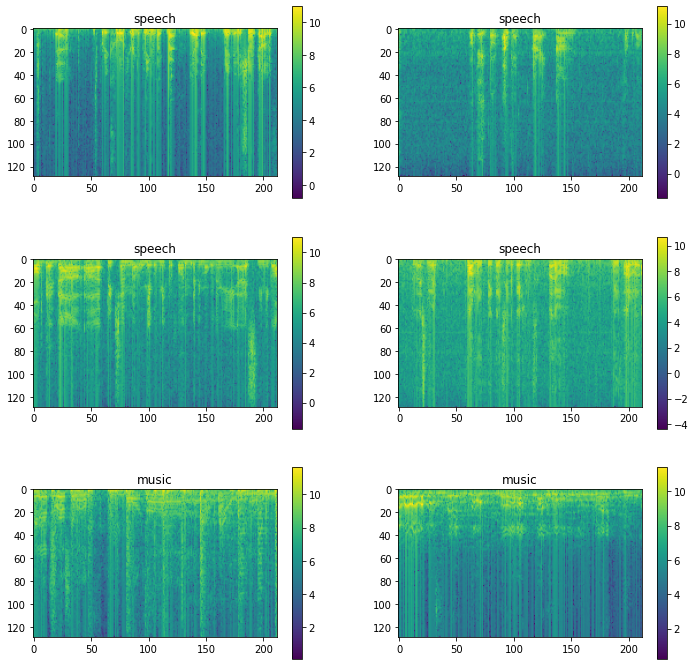

In [83]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

# Task 6: Create the Model

In [52]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense

input_ = Input(shape=(129,212))
x = Lambda(lambda x: tf.expand_dims(x,axis=-1))(input_)

for i in range(4):
  num_filters = 2**(5+i)
  x = Conv2D(num_filters,3)(x)
  x = BatchNormalization()(x)
  x = Activation("tanh")(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(120,activation = "relu")(x)
x = Dropout(0.4)(x)
x = Dense(1,activation = "sigmoid")(x)

model = tf.keras.models.Model(input_,x)


In [53]:
model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-6),metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 127, 210, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 103, 64)       1849

# Task 7: Model Training

In [54]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        self.target_acc = kwargs.get("target_acc") or 0.95
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [84]:
_ = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),batch_size=12,epochs=500,verbose=False,callbacks=[CustomCallback()])

Epoch:   4, Loss: 0.3377, Acc: 0.8632, Val Loss: 0.2140, Val Acc: 0.9200
Epoch:   9, Loss: 0.2219, Acc: 0.9060, Val Loss: 0.1851, Val Acc: 0.9200
Epoch:  14, Loss: 0.1608, Acc: 0.9615, Val Loss: 0.1706, Val Acc: 0.9300
Epoch:  19, Loss: 0.1511, Acc: 0.9444, Val Loss: 0.1559, Val Acc: 0.9367
Epoch:  24, Loss: 0.1210, Acc: 0.9594, Val Loss: 0.1461, Val Acc: 0.9500
Epoch:  29, Loss: 0.1355, Acc: 0.9551, Val Loss: 0.1332, Val Acc: 0.9567
Target val accuracy achieved 0.9566666483879089


# Task 8: Predictions

In [94]:
example = next(data_iter)

x_test,y_test = preprocess(example)

preds = model.predict(x_test)
pred_classes = tf.squeeze(tf.cast(preds>0.5,tf.int8))

In [95]:
pred_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 0, 0, 0], dtype=int8)>

In [96]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0])>